### Imports

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Constants

In [16]:
base_path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits")
plotdir = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/plots")
split_sets = {
    "5pct_70": base_path / "5pct_70",
    "5pct_80": base_path / "5pct_80",
    "15pct_70": base_path / "15pct_70",
    "15pct_80": base_path / "15pct_80",
    "25pct_70": base_path / "25pct_70",
    "25pct_80": base_path / "25pct_80"
}

### Load Data

In [17]:
# Helper func
def load_split_data(split_path):
    split_path = Path(split_path)
    X_train = pd.read_csv(split_path / "X_train.csv", index_col=0)
    X_test = pd.read_csv(split_path / "X_test.csv", index_col=0)
    y_train = pd.read_csv(split_path / "y_train.csv", index_col=0).squeeze()
    y_test = pd.read_csv(split_path / "y_test.csv", index_col=0).squeeze()
    return X_train, X_test, y_train, y_test


### Model function

In [18]:
def evaluate_lasso_logreg(X_train, y_train, X_test, y_test, cv_folds=5):
    clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42 , C = 1000)

    # Cross-validation accuracy
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

    # Fit on full training data, evaluate on test
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    #test_acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf = confusion_matrix(y_test, y_pred)

    return {
        "cv_mean_acc": cv_scores.mean(),
        "cv_std_acc": cv_scores.std(),
        #"test_acc": test_acc,
        "report": report,
        "conf_matrix": conf
    }



### 5-Fold

In [19]:
results = []

for name, path in split_sets.items():
    X_train, X_test, y_train, y_test = load_split_data(path)
    out = evaluate_lasso_logreg(X_train, y_train, X_test, y_test)

    results.append({
        "Split": name,
        "Samples": X_train.shape[0],
        "Features": X_train.shape[1],
        "CV Accuracy": round(out["cv_mean_acc"], 4),
        #"Test Accuracy": round(out["test_acc"], 4)
    })

results_df = pd.DataFrame(results).sort_values("Split")
results_df

,Split,Samples,Features,CV Accuracy
2,15pct_70,357,5870,0.7030
3,15pct_80,408,5870,0.7426
4,25pct_70,357,9784,0.7338
5,25pct_80,408,9784,0.7745
0,5pct_70,357,1956,0.6579
1,5pct_80,408,1956,0.6569


### 10-Fold

In [20]:
results = []

for name, path in split_sets.items():
    X_train, X_test, y_train, y_test = load_split_data(path)
    out = evaluate_lasso_logreg(X_train, y_train, X_test, y_test, cv_folds=10)

    results.append({
        "Split": name,
        "Samples": X_train.shape[0],
        "Features": X_train.shape[1],
        "CV Accuracy": round(out["cv_mean_acc"], 4),
        #"Test Accuracy": round(out["test_acc"], 4)
    })

results_df = pd.DataFrame(results).sort_values("Split")
results_df

,Split,Samples,Features,CV Accuracy
2,15pct_70,357,5870,0.7167
3,15pct_80,408,5870,0.7671
4,25pct_70,357,9784,0.7500
5,25pct_80,408,9784,0.7896
0,5pct_70,357,1956,0.6582
1,5pct_80,408,1956,0.6494


In [21]:
# View for a specific split
split_to_inspect = "25pct_80"
X_train, X_test, y_train, y_test = load_split_data(split_sets[split_to_inspect])
out = evaluate_lasso_logreg(X_train, y_train, X_test, y_test, cv_folds=10)

# Classification report
pd.DataFrame(out["report"]).T

,precision,recall,f1-score,support
0,0.812500,0.696429,0.750000,56.000000
1,0.685185,0.804348,0.740000,46.000000
accuracy,0.745098,0.745098,0.745098,0.745098
macro avg,0.748843,0.750388,0.745000,102.000000
weighted avg,0.755084,0.745098,0.745490,102.000000


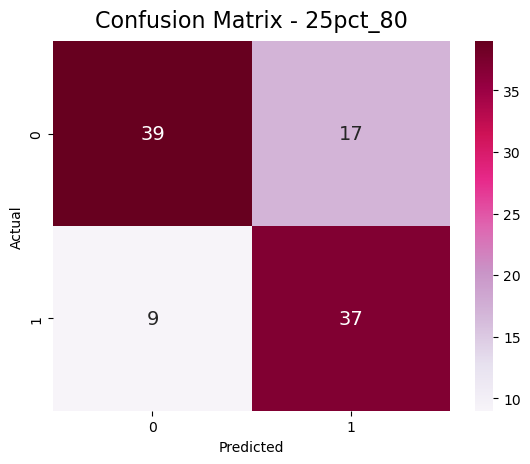

In [25]:
# Confusion matrix heatmap
sns.heatmap(out["conf_matrix"], annot=True, fmt='d', cmap="PuRd", cbar=True, annot_kws= {"fontsize":14})
plt.title(f"Confusion Matrix - {split_to_inspect}", fontsize = 16 , pad = 10)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(plotdir/"CF_logistic.png", bbox_inches="tight", dpi=300)
plt.show()

### Save Data


In [23]:
results_df.to_csv("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/Logistic_results.csv")